<a href="https://colab.research.google.com/github/RonBartov/American_Sign_Language_Classification/blob/main/Copy_of_Deep_Learning_Final_Project_ASL_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Final Project- American Sign Language Images Classification**

In [9]:
import cv2
import pandas as pd
from PIL import Image as Im 
from PIL import ImageOps
from google.colab import drive
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision.utils import make_grid
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Additional Functions That Will Be Used In The Project**

In [62]:
# Here we will write a function that will be used throughout the project 
# whenever we want to display an image from the dataframe or from the images we 
# took from our personal device

def plot_image(img_name=None, img_source=None, int_to_letter_dict = None,img_source_name=None):
  ''' Inputs:
      img_name: full name of the image including extenison
      img_source_name: 'iPhone' or 'MNIST'
      img_source: for 'iPhone' use insert the path of the iPhone images and for MNIST image insert the data frame of the MNIST
      int_to_letter_dict: dictionary that maps int (label's number) to their corresponding letters {int: leter}
  '''
  
  if img_source_name == 'iPhone':
    print("Image Name: " + img_name + "\n")
    img_path = img_source + "/" + img_name
    img_rgb = Im.open(img_path)
    img_gray = ImageOps.grayscale(img_rgb)
    resized_gray_img = img_gray.resize((28, 28))

    print("Size of the original image:", np.array(img_rgb).shape)
    print("Size of the gray image:", np.array(img_gray).shape)
    print("Size of the gray resized image:", np.array(resized_gray_img).shape)

    # Plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original Image")
    axs[1].imshow(img_gray, cmap='gray')
    axs[1].set_title("Gray Image")
    axs[2].imshow(resized_gray_img, cmap='gray')
    axs[2].set_title("Gray Resized Image")

  elif img_source_name == 'MNIST':
    return None

  return None

In [135]:
def bar_graph_plot(pd_series, x_label='',y_label='',Title=''):
  '''
  Inputs:
  pd_series: pandas series of shape(N,)
  '''
  mean = pd_series.values.mean()
  plt.bar(pd_series.index, pd_series.values)
  plt.xticks(pd_series.index + 0.5, pd_series.index)
  plt.axhline(y=mean, color='red', linestyle='--')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(Title)
  
  # add average value to plot
  plt.annotate("Average: {:.6f}".format(mean), xy=(0, mean), xycoords='data',
              xytext=(0.3, 0.85), textcoords='figure fraction',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color='black'),
              ha='center', va='bottom')
  plt.show()
  return None

# **General Background and Goals**

Sign languages are visual languages that use hand gestures, facial expressions, and body language to convey some meaning. They are used as a means of communication by deaf and hard-of-hearing individuals in many countries around the world. Unlike spoken languages, sign languages are not based on a particular spoken language and are unique to the deaf communities in which they are used.

Despite the widespread use of sign languages, there is still much work to be done in improving communication between deaf and hearing individuals and the development of technologies that can recognize and understand sign languages is an important step towards this goal. 

**In our project**, we are exploring the use of deep learning for American Sign Language (ASL) recognition by teaching our neural network to classify between different ASL letters. The dataset we are using is the ASL MNIST dataset, which is a dataset that has been adapted to specifically focus on the recognition of American Sign Language.


###**Data Description**
Our data composed from 28x28 grayscale images (one channel images), each one represents one of the 24 american letters that **not require any motion**, i.e all the american letters except J and Z.



The data contains 34,627 images in total and it devided into the following types:

1) Test and Validation data- 27,455 images

2) Test Data- 7,172 images


In addition, the first column of the data represents the labels of the images as a numeric values. We have in total 26 american letters that their labels are the numbers 0-25 correspondingly to the order of the letters, and because we are not using the letters J and Z (which require motion as we mentioned before) we have the left only with the labels 0-8 and 10-24.


###**Additional Goal**

In addition to the classification of the MNIST data itself, our goal in this project is to be able to classify letter from an image that was taken from our personal phones. This image will have a different properties, due to the type of the camera, initial resolution and also the enviroment where the image were taken, thus we will expect to get lower accuracy for those king of images.

Below you can see one example for an image that was taken with iPhone. The image initial rezolution is 2048x2048 and its type is RGB.

Image Name: ASL_Image_D.jpeg

Size of the original image: (2048, 2048, 3)
Size of the gray image: (2048, 2048)
Size of the gray resized image: (28, 28)


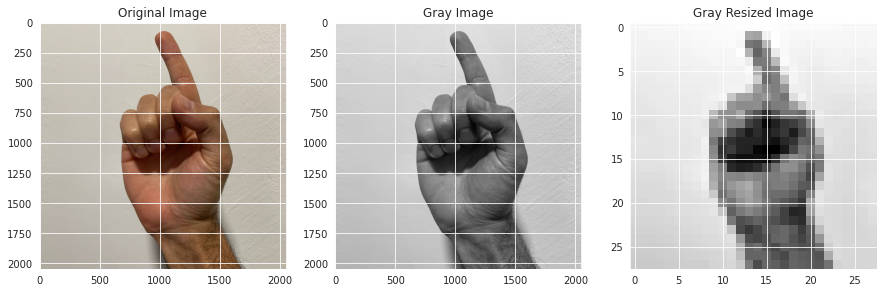

In [63]:
iPhone_images_path ="/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/ASL_Images_From_Iphone"
plot_image(img_name='ASL_Image_D.jpeg', img_source=iPhone_images_path,img_source_name='iPhone')

#**Importing the MNIST Data and Learning its Properties**

In order to start our training part properly, we would like to learn the data in the best way we can and to work with it in a right way according to its properties. That includes the following:

**1) High-level understanding of the data-** Checking the number of samples, classes, and the distribution of the data, such as the range of pixels values, mean and variance. 


**2) Splitting the data-** The ASL MNIST data already splitted into "train" and "test" sets, thus we will focus on splitting the "train" data into "train" and "validation" sets.

**3) Preprocessing-** Includes normalizing the data, removing missing values, and transforming the data so that it has the correct format for our model.

In [64]:
# Define the data paths

# Ron's paths
csv_train_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_train.zip"
csv_test_path = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning Final Project- ASL/sign_mnist_test.zip"

# Aviv's paths
# csv_train_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_train.csv"
# csv_test_path = "/content/gdrive/MyDrive/DP_course/final/data/sign_mnist_test.csv"


In [56]:
#letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# numbers = range(26)
# letter_to_number = dict(zip(letters, numbers))

In [66]:
df_train = pd.read_csv(csv_train_path)
df_test = pd.read_csv(csv_test_path)

In [67]:
# presenting few rows from the train dataframe 
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


As we see above, each row in the data represents an image. The first column is the label value and the rest are the pixels values. Because the images are of size 28x28, then we have 784 pixels values in total.

## **1) High-level understanding of the data**

In [74]:
# data shape
print('Shape the unified training and validation set: ', df_train.shape)
print('Shape of samples in the test set: ', df_test.shape)

Shape the unified training and validation set:  (27455, 785)
Shape of samples in the test set:  (7172, 785)


In [77]:
# check for missing values in the data
print("Missing values in the unified training and validation set: ", df_train.isnull().sum().sum())
print("Missing values in the test set: ", df_test.isnull().sum().sum())

Missing values in the unified training and validation set:  0
Missing values in the test set:  0


In [95]:
# calculate the appearence percentage for each label in the unified training and validation set
count_label = df_train.groupby('label').size() 
count_label_percentage = count_label/len(df_train.axes[0])
count_label_percentage 

label
0     0.041013
1     0.036787
2     0.041668
3     0.043562
4     0.034857
5     0.043854
6     0.039701
7     0.036897
8     0.042324
10    0.040575
11    0.045201
12    0.038427
13    0.041923
14    0.043562
15    0.039628
16    0.046585
17    0.047132
18    0.043671
19    0.043198
20    0.042287
21    0.039410
22    0.044618
23    0.042397
24    0.040721
dtype: float64

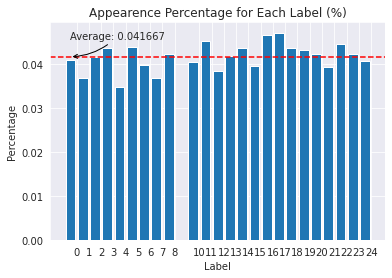

In [136]:
 bar_graph_plot(count_label_percentage, x_label='Label',y_label='Percentage',Title='Appearence Percentage for Each Label (%)')

In [100]:
# calculate the distance from the average number of images per label (in terms of percentage)
label_avg_count = count_label.sum()//24
print("Average number of samples per label is: ", label_avg_count)
label_diffrence_from_avg = abs(count_label - label_avg_count)/label_avg_count
label_diffrence_from_avg

Average number of samples per label is:  1143


label
0     0.014873
1     0.116360
2     0.000875
3     0.046369
4     0.162730
5     0.053368
6     0.046369
7     0.113736
8     0.016623
10    0.025372
11    0.085739
12    0.076990
13    0.006999
14    0.046369
15    0.048119
16    0.118985
17    0.132108
18    0.048994
19    0.037620
20    0.015748
21    0.053368
22    0.071741
23    0.018373
24    0.021872
dtype: float64

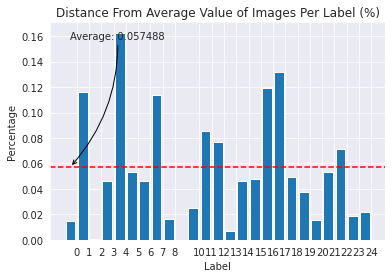

In [137]:
bar_graph_plot(label_diffrence_from_avg, x_label='Label',y_label='Percentage',Title='Distance From Average Value of Images Per Label (%)')

In [5]:
lenn = len(df_train)
train_size = int(0.8 * len(df_train))
val_size = len(df_train) - train_size

df_val = df_train[train_size:]
df_train = df_train[:train_size-1]
print(len(df_train))

21963


## **Presenting an image from the data as an example**

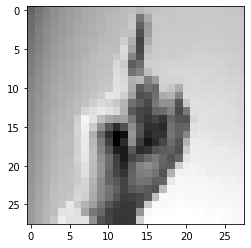

In [7]:
pic_df = df_train.iloc[0:1,1:]
pic = pic_df.to_numpy()
plt.imshow(pic.reshape(28,28), cmap="gray")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

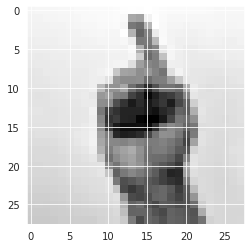

In [28]:
# resize the image
ext_img_gray_res = ext_img_gray.resize((28, 28))
np_ext_img_gray = np.array(ext_img_gray_res)
np.shape(np_ext_img_gray)
plt.imshow(ext_img_gray_res, cmap='gray')

## **Check if the data is balanced**

In order to know how to train our network weights properly, we would like to know if we have almost the same amount of images from each label, which can be treated as balanced training data. 

In [13]:
# calculate the appearence percentage for each label
count_label = df_train.groupby('label').size() 
count_label_percentage = count_label/len(df_train.axes[0])
count_label_percentage

label
0     0.040614
1     0.037108
2     0.041160
3     0.044211
4     0.035332
5     0.043437
6     0.039840
7     0.036106
8     0.043346
10    0.040204
11    0.045486
12    0.037609
13    0.042253
14    0.043846
15    0.039612
16    0.044985
17    0.046943
18    0.044438
19    0.043528
20    0.042526
21    0.039339
22    0.044712
23    0.042071
24    0.041297
dtype: float64

In [14]:
# calculate the distance to the average number of images per label (in terms of number of images)
label_avg_count = count_label.sum()//24
print("The average number of samples per label is: ", label_avg_count)
label_diffrence_from_avg = abs(count_label - label_avg_count)
label_diffrence_from_avg

The average number of samples per label is:  915


label
0      23
1     100
2      11
3      56
4     139
5      39
6      40
7     122
8      37
10     32
11     84
12     89
13     13
14     48
15     45
16     73
17    116
18     61
19     41
20     19
21     51
22     67
23      9
24      8
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


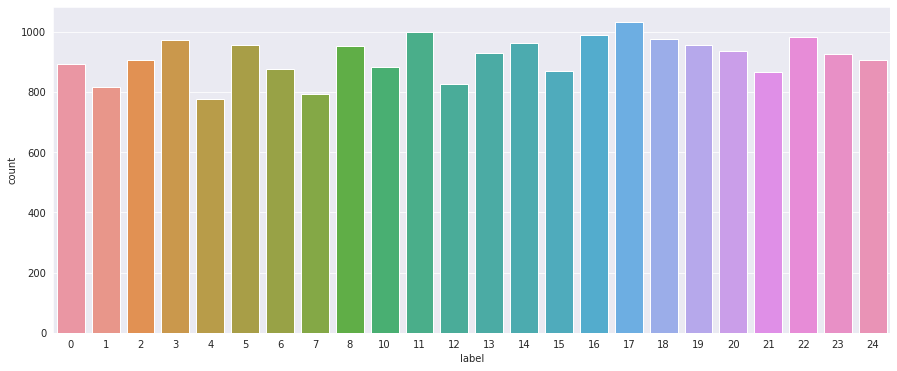

In [16]:
# visualize the label distribution
y_train = df_train['label']
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
sns.countplot(y_train)

## **Split the data into train and validation**

In [ ]:
# y_train = df_train['label']
# y_test = df_test['label']
# del df_train['label']
# del df_test['label']
# x_train = df_train.values
# x_test = df_test.values
# x_train = x_train / 255
# x_test = x_test / 255
# x_train = x_train.reshape(-1,28,28,1)
# x_test = x_test.reshape(-1,28,28,1)
# x_test_tensor = torch.Tensor(x_test).swapaxes(1, 3).swapaxes(2 , 3)
# x_train_tensor = torch.Tensor(x_train).swapaxes(1, 3).swapaxes(2 , 3)

In [ ]:
# print(x_test.shape)
# print(x_test_tensor.shape)

(7172, 28, 28, 1)
torch.Size([7172, 1, 28, 28])


In [ ]:
# norm_mean = 0.5 
# norm_std = 0.5 
# output_size = 24      # there are 10 classes
# train_loader = torch.utils.data.DataLoader(df_train, batch_size=500, shuffle=True , transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((norm_mean,), (norm_std,))
#                    ]))
# test_loader = torch.utils.data.DataLoader(df_test, batch_size=500, shuffle=True)
# print(train_loader.dataset.__len__())
# print(test_loader.dataset.__len__())

## **Creating the neural network for the classification**

Consider ResNet and VGG

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=(3, 3), stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=(3, 3), stride=1, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=(3, 3), stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        
        self.fc1 = nn.Linear(25 * 4 * 4, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 25)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)

        x = x.view(-1, 25 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

## **Creating the training function**

In [18]:
def test(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        return accuracy

In [19]:
def data_loader(csv_data ,batch_size):
    # Convert the dataframe into a PyTorch tensor
    data = torch.tensor(csv_data.values, dtype=torch.float32)
    
    # Split the data into inputs (images) and targets (labels)
    inputs = data[:, 1:]
    targets = data[:, 0].long()
    
    # Normalize the inputs
    inputs = inputs / 255.0
    
    # Convert inputs into a 4D tensor for processing by the model
    inputs = inputs.view(-1, 1, 28, 28)
    
    # Create a TensorDataset from the inputs and targets
    dataset = TensorDataset(inputs, targets)
    
    # Create a DataLoader from the dataset
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
def train_model(train_data,val_data, model, criterion, optimizer, num_epochs = 500, batch_size= 500):
    model.train()

    # # Create a DataLoader from the dataset
    data_train = data_loader(train_data , batch_size)
    data_val = data_loader(val_data , batch_size)
    n = 0
    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(data_train):
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            #loss = criterion(outputs.cpu(), labels.cpu())
            loss = F.nll_loss(outputs.cpu(), labels.cpu())
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss
            n+=1
            if n%50 ==0:
              iters_sub.append(n)
              train_cost = float(loss.detach().numpy())
              data_train_2 = data_loader(train_data[1:2000] , batch_size)
              train_acc = test(model, data_train_2 , criterion)

              train_accs.append(train_acc)
              val_acc = test(model, data_val , criterion)
              val_accs.append(val_acc)
              print(f'Epoch [{epoch+1}/{num_epochs}] '+"Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
              n, val_acc * 100, train_acc * 100, train_cost))
              #print(f'Epoch [{epoch+1}/{num_epochs}] , Iteration[{n}], Loss: {loss.item()}')
            
    print('Finished Training')
    return iters, losses, iters_sub, train_accs, val_accs

##Train the model

In [21]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model.cuda(), (1,28,28))

input shape: torch.Size([2, 1, 28, 28])
second shape: torch.Size([2, 75, 14, 14])
3 shape: torch.Size([2, 50, 7, 7])
4 shape: torch.Size([2, 25, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 75, 28, 28]             750
       BatchNorm2d-2           [-1, 75, 28, 28]             150
         MaxPool2d-3           [-1, 75, 14, 14]               0
            Conv2d-4           [-1, 50, 14, 14]          33,800
           Dropout-5           [-1, 50, 14, 14]               0
       BatchNorm2d-6           [-1, 50, 14, 14]             100
         MaxPool2d-7             [-1, 50, 7, 7]               0
            Conv2d-8             [-1, 25, 7, 7]          11,275
       BatchNorm2d-9             [-1, 25, 7, 7]              50
        MaxPool2d-10             [-1, 25, 4, 4]               0
           Linear-11                  [-1, 512]         205,312
          Dropo

In [22]:
model.to(device)
iters, losses, iters_sub, train_accs, val_accs = train_model(df_train,df_val, model, criterion, optimizer, num_epochs = 3, batch_size= 128)


Epoch [1/3] Iter 50. [Val Acc 87%] [Train Acc 87%, Loss 0.377559]
Epoch [1/3] Iter 100. [Val Acc 98%] [Train Acc 98%, Loss 0.055588]
Epoch [1/3] Iter 150. [Val Acc 100%] [Train Acc 100%, Loss 0.009531]
Epoch [2/3] Iter 200. [Val Acc 100%] [Train Acc 100%, Loss 0.001765]
Epoch [2/3] Iter 250. [Val Acc 100%] [Train Acc 100%, Loss 0.001023]
Epoch [2/3] Iter 300. [Val Acc 100%] [Train Acc 100%, Loss 0.000588]
Epoch [3/3] Iter 350. [Val Acc 100%] [Train Acc 100%, Loss 0.000475]
Epoch [3/3] Iter 400. [Val Acc 100%] [Train Acc 100%, Loss 0.000202]
Epoch [3/3] Iter 450. [Val Acc 100%] [Train Acc 100%, Loss 0.000272]
Epoch [3/3] Iter 500. [Val Acc 100%] [Train Acc 100%, Loss 0.000250]
Finished Training


In [23]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs*100, label="Train")
    plt.plot(iters_sub, val_accs*100, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

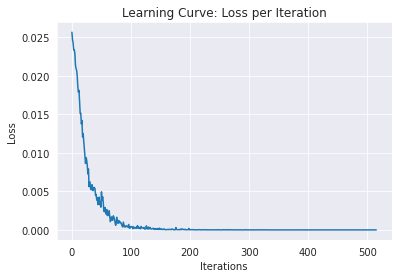

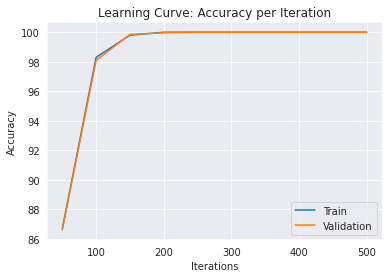

In [24]:
val_accs = np.array(val_accs)
train_accs = np.array(train_accs)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

In [25]:
test_loader = data_loader(df_test , 120)

In [ ]:
##lets see some results

In [26]:
xxxxx = test(model, test_loader, criterion)
print(xxxxx)

0.9485499163413273


In [ ]:
#torch.save(model, "/content/gdrive/MyDrive/DP_course/final/data/model1.pk.")